In [1]:
import os
from pathlib import Path
import glob
from datetime import datetime

import numpy as np
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torch.utils
import torchvision as tv
from torchvision import transforms as tf

import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
import sys
sys.path.append('../')

In [3]:
from utils_ import *
from io_ import *
from data_ import *
from transforms import *
from models import *
from training import *
from visualizations import *
from monitoring import *
%reload_ext autoreload
%autoreload 2

In [4]:
CLASS_NAMES = ['building', 'tree', 'low-vegetation', 'clutter', 'car', 'pavement']
NCLASSES = len(CLASS_NAMES)

In [5]:
S3_BUCKET = 'raster-vision-ahassan'
S3_ROOT = f'potsdam/experiments/output/tmp'

In [6]:
io_handler = S3IoHandler(
    local_root='tmp', 
    s3_bucket=S3_BUCKET, 
    s3_root=S3_ROOT
)

# Data

In [7]:
with open('../../potsdam/data/potsdam.pkl', 'rb') as f:
    potsdam_dict = pickle.load(f)


## Prepare datasets

In [8]:
CHIP_SIZE = 400
STRIDE = 200
DOWNSAMPLING = 1

In [9]:
CHANNELS = [ch_R, ch_G, ch_B, ch_IR, ch_E]
_, val_transform, x_transform, y_transform = tfs_potsdam(channels=CHANNELS, downsampling=DOWNSAMPLING)
original_ds = Potsdam(potsdam_dict, chip_size=CHIP_SIZE, stride=STRIDE, tf=val_transform)

In [10]:
CHANNELS = [ch_E]
_, val_transform, x_transform, y_transform = tfs_potsdam(channels=CHANNELS, downsampling=DOWNSAMPLING)
val_ds_e     = Potsdam(potsdam_dict, chip_size=CHIP_SIZE, stride=STRIDE, tf=val_transform  , x_tf=x_transform, y_tf=y_transform)

CHANNELS = [ch_R, ch_G, ch_B]
_, val_transform, x_transform, y_transform = tfs_potsdam(channels=CHANNELS, downsampling=DOWNSAMPLING)
val_ds_rgb   = Potsdam(potsdam_dict, chip_size=CHIP_SIZE, stride=STRIDE, tf=val_transform  , x_tf=x_transform, y_tf=y_transform)

CHANNELS = [ch_R, ch_G, ch_B, ch_E]
_, val_transform, x_transform, y_transform = tfs_potsdam(channels=CHANNELS, downsampling=DOWNSAMPLING)
val_ds_rgbe = Potsdam(potsdam_dict, chip_size=CHIP_SIZE, stride=STRIDE, tf=val_transform  , x_tf=x_transform, y_tf=y_transform)

CHANNELS = [ch_R, ch_G, ch_B, ch_IR, ch_E]
_, val_transform, x_transform, y_transform = tfs_potsdam(channels=CHANNELS, downsampling=DOWNSAMPLING)
val_ds_rgbire = Potsdam(potsdam_dict, chip_size=CHIP_SIZE, stride=STRIDE, tf=val_transform  , x_tf=x_transform, y_tf=y_transform)

In [11]:
TRAIN_SPLIT = 0.85
train_split_size = int((len(original_ds) * TRAIN_SPLIT) // 1)
val_split_size = len(original_ds) - train_split_size
train_split_size, val_split_size

print('train_split_size', train_split_size)
print('val_split_size', val_split_size)

inds = np.arange(len(original_ds))

train_split_size 12867
val_split_size 2271


In [12]:
train_sampler = torch.utils.data.SubsetRandomSampler(inds[:train_split_size])
val_sampler = torch.utils.data.SubsetRandomSampler(inds[train_split_size:])

assert len(set(train_sampler.indices) & set(val_sampler.indices)) == 0

In [13]:
val_iter = iter(val_sampler)

In [302]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_input_pred(model, batch, labels, val_idx=None):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8), gridspec_kw={'width_ratios': [1, 1, 1, 1]})
    ax1.imshow(batch[0, :3].permute(1, 2, 0))
    ax1.set_title(f'RGB')
    ax1.axis('off')
    
    ax2.imshow(torch.ones_like(batch[0, -1]).float(), cmap='gray')
#     ax2.set_title('N/A')
    ax2.axis('off')

    im = ax3.imshow(labels)
    ax3.set_title('Ground Truth')
    divider = make_axes_locatable(ax3)
    cax3 = divider.append_axes("right", size="5%", pad=0.05)
    f.colorbar(im, cax=cax3)
    ax3.axis('off')

    model.eval()
    with torch.no_grad():
        pred_rgb = model(batch).permute(0, 2, 3, 1).argmax(dim=-1).squeeze()
    im = ax4.imshow(pred_rgb)
    ax4.set_title('Model Prediction')
    divider = make_axes_locatable(ax4)
    cax4 = divider.append_axes("right", size="5%", pad=0.05)
    f.colorbar(im, cax=cax4)
    ax4.axis('off')
    
    plt.show()

def get_pos_neg_saliency(g):
    gpos = g.clamp(min=0) / g.max()
    gneg = (-g).clamp(min=0) / (-g.min())
    return gpos, gneg

def plot_saliency(g, idx=[1, 2, 3], title='', cmap=None, show_colorbar=False):
    gabs = g.abs()
    gmax, gmin = gabs.max(), gabs.min()
    gn = ((gabs - gmin) / (gmax - gmin))[..., idx].sum(dim=-1)
    gpos, gneg = get_pos_neg_saliency(g)

    f = plt.figure(figsize=(18, 6))
    f.tight_layout()

    f.suptitle(title)
    ax = f.add_subplot(131)
    im = ax.imshow(gn, cmap='gray')
    ax.set_title('Abs saliency')
    if show_colorbar:
        plt.colorbar(im, ax=ax)

    ax = f.add_subplot(132)
    im = ax.imshow(gpos[..., idx].squeeze(), cmap=cmap)
    ax.set_title('Positive saliency')
    if show_colorbar:
        plt.colorbar(im, ax=ax)

    ax = f.add_subplot(133)
    im = ax.imshow(gneg[..., idx].squeeze(), cmap=cmap)
    ax.set_title('Negative saliency')
    if show_colorbar:
        plt.colorbar(im, ax=ax)

    plt.show()

In [15]:
val_idx = next(val_iter)
val_idx = 13028
batch, labels = val_ds_rgbe[val_idx]
batch_rgbire, _ = val_ds_rgbire[val_idx]
batch = batch.unsqueeze(0)
batch_rgbire = batch_rgbire.unsqueeze(0)
batch.requires_grad = True
batch_rgbire.requires_grad = True
# 14463
print(val_idx)

13028


# Model

## RGB-E, merge after 7

In [11]:
model_rgbe_7 = None
torch.cuda.empty_cache()
model_rgbe_7 = get_deeplab_custom(NCLASSES, in_channels=3, pretrained=True)
model_e_tmp = get_deeplab_custom(NCLASSES, in_channels=1, pretrained=True)

model_rgbe_7.m.backbone = DeeplabDoublePartialBackbone(model_rgbe_7.m.backbone, model_e_tmp.m.backbone, 7)
model_rgbe_7 = model_rgbe_7.cuda()

In [12]:
model_rgbe_7.m.aux_classifier = None

In [13]:
name = 'ss_rgbp_ep_deeplab_resnet101p_merge_after_backbone_partial_7'

io_handler.load_model_weights(
    model_rgbe_7, 
    s3_path=f'potsdam/experiments/output/{name}/best_model/best_acc', 
    tgt_path=f'models/{name}'
)

In [ ]:
viz_conv_layer_filters(model_rgbe_7.m.backbone.head[1][0][0].weight.data, show=True, normalize=True, scale_each=False, figsize=(6, 6))
viz_conv_layer_filters(model_rgbe_7.m.backbone.head[1][1][0].weight.data, show=True, normalize=True, scale_each=False, figsize=(6, 6))
# viz_conv_layer_filters(model_rgbe_1x1[0][0].original_conv.weight.data, show=True, normalize=True, scale_each=True, figsize=(6, 6))


## RGB-E, merge after 1

In [278]:
model_rgbe_1 = None
torch.cuda.empty_cache()
model_rgbe_1 = get_deeplab_custom(NCLASSES, in_channels=3, pretrained=True)
model_e_tmp = get_deeplab_custom(NCLASSES, in_channels=1, pretrained=True)

model_rgbe_1.m.backbone = DeeplabDoublePartialBackbone(model_rgbe_1.m.backbone, model_e_tmp.m.backbone, 1)
model_rgbe_1 = model_rgbe_1.cuda()

In [279]:
name = 'ss_rgbp_ep_deeplab_resnet101p_merge_after_backbone_partial_1_lowdata'

io_handler.load_model_weights(
    model_rgbe_1, 
    s3_path=f'potsdam/experiments/output/{name}/best_model/best_acc', 
    tgt_path=f'models/{name}'
)

In [280]:
model_rgbe_1.m.aux_classifier = None

In [ ]:
viz_conv_layer_filters(model_rgbe_1.m.backbone.head[1][0][0].weight.data, show=True, normalize=True, scale_each=False, figsize=(6, 6))
viz_conv_layer_filters(model_rgbe_1.m.backbone.head[1][1][0].weight.data, show=True, normalize=True, scale_each=False, figsize=(6, 6))
# viz_conv_layer_filters(model_rgbe_1x1[0][0].original_conv.weight.data, show=True, normalize=True, scale_each=True, figsize=(6, 6))


## RGBIRE

In [77]:
model_rgbire = get_deeplab_custom(NCLASSES, in_channels=5, pretrained=True).cuda()
model_rgbire.m.aux_classifier = None

In [78]:
name = 'ss_rgbire_deeplab_resnet101p'

io_handler.load_model_weights(
    model_rgbire, 
    s3_path=f'potsdam/experiments/output/{name}/best_model/best_acc', 
    tgt_path=f'models/{name}'
)

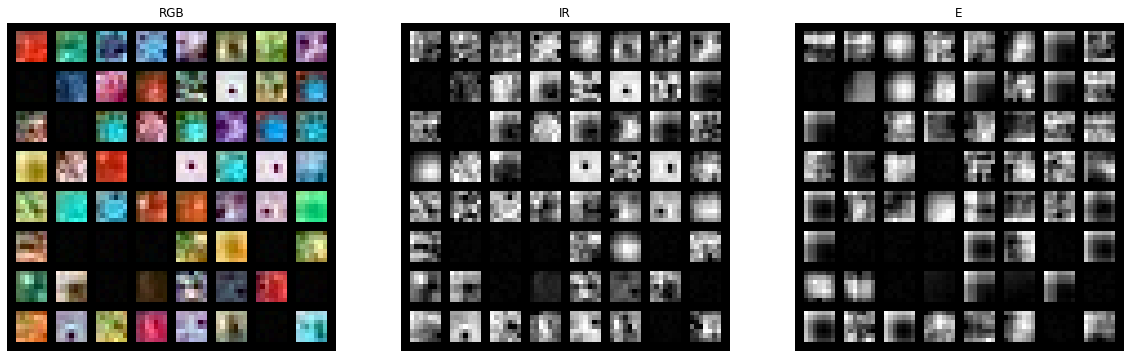

In [94]:
f = plt.figure(figsize=(20, 14))
f.tight_layout()
for i, (idx, title) in enumerate(zip([[0, 1, 2], [3], [4]], ['RGB', 'IR', 'E'])):
    ax = f.add_subplot(f'13{i + 1}')
    fs = model_rgbire.m.backbone.conv1.weight.data[:, idx].detach().cpu()
    grid = tv.utils.make_grid(fs, normalize=True, scale_each=True).permute(1, 2, 0)
    ax.imshow(grid)
    ax.set_title(title)
    plt.axis('off')
plt.show()

## RGBE, merge after first conv

In [67]:
class ModifiedConv_add_old(nn.Module):

	def __init__(self, conv, new_conv_in_channels=1):
		super().__init__()

		self.orig_in = conv.in_channels
		self.orig_out = conv.out_channels

		self.new_in = new_conv_in_channels
		self.new_out = self.orig_out

		self.original_conv = conv
		self.new_conv = nn.Conv2d(self.new_in, self.new_out, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).cuda()

	def forward(self, X):
		# X.shape = (N, Ch, H, W)
		orig_out = self.original_conv(X[:, :self.orig_in])
		new_out = self.new_conv(X[:, -self.new_in:])
		out = orig_out + new_out

		return out

In [68]:
model_rgbe_conv = get_deeplab_custom(NCLASSES, in_channels=3, pretrained=True).cuda()
model_rgbe_conv.m.backbone.conv1 = ModifiedConv_add_old(model_rgbe_conv.m.backbone.conv1, new_conv_in_channels=1)
model_rgbe_conv.m.aux_classifier = None

In [69]:
name = 'ss_rgbp_e_deeplab_resnet101p'

io_handler.load_model_weights(
    model_rgbe_conv, 
    s3_path=f'potsdam/experiments/output/{name}/best_model/best_acc', 
    tgt_path=f'models/{name}'
)

## RGB-noise, merge after first conv

In [32]:
model_rgbn_conv = get_deeplab_custom(NCLASSES, in_channels=3, pretrained=True).cuda()
model_rgbn_conv.m.backbone.conv1 = ModifiedConv_add(model_rgbn_conv.m.backbone.conv1, new_conv_in_channels=1)
model_rgbn_conv.m.aux_classifier = None

In [44]:
name = 'ss_rgbp_noise_deeplab_resnet101p'

io_handler.load_model_weights(
    model_rgbn_conv, 
    s3_path=f'potsdam/experiments/output/{name}/best_model/best_acc', 
    tgt_path=f'models/{name}'
)

## RGB

In [30]:
model_rgb = get_deeplab_custom(NCLASSES, in_channels=3, pretrained=True, pretrained_backbone=False)

In [31]:
name = 'ss_rgb_deeplab_resnet101p_lowdata'

io_handler.load_model_weights(
    model_rgb, 
    s3_path=f'potsdam/experiments/output/{name}/best_model/best_acc', 
    tgt_path=f'models/{name}'
)

In [ ]:
viz_conv_layer_filters(model_rgb.m.backbone.conv1.weight.data, show=True, normalize=True, scale_each=True, figsize=(10, 10))

## E, no pretraining

In [56]:
model_e = get_deeplab_custom(NCLASSES, in_channels=1, pretrained=False, pretrained_backbone=False)

In [58]:
name = 'ss_e_deeplab_resnet101'

io_handler.load_model_weights(
    model_e, 
    s3_path=f'potsdam/experiments/output/{name}/best_model/best_acc', 
    tgt_path=f'models/{name}'
)

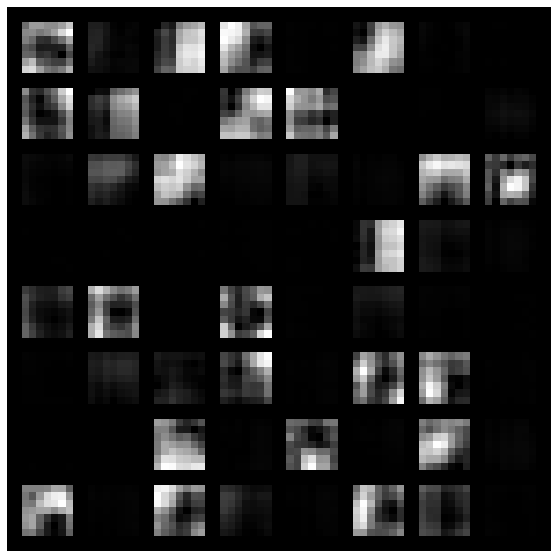

In [59]:
viz_conv_layer_filters(model_e.m.backbone.conv1.weight.data, show=True, normalize=True, scale_each=True, figsize=(10, 10))

# Smooth grad

In [18]:
class Backprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model, first_layers):
        self.model = model
        self.first_layers = first_layers
        self.gradients = []
        # Put model in evaluation mode
        self.model.eval()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients.append(grad_in[0])
        # Register hook to the first layer
        for layer in self.first_layers:
            layer.register_backward_hook(hook_function)

    def generate_gradients(self, input_image, labels, target_class):
        # Forward pass
        self.gradients = []
        model_output = F.softmax(self.model(input_image), dim=1)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.zeros_like(model_output)
        one_hot_output[:, target_class] = (labels == target_class).float()
        # Backward pass
        model_output.backward(gradient=one_hot_output)


In [19]:
def cat_grads(gs):
    return torch.cat(gs[::-1], dim=1)

def smooth_grad(backprop_obj, batch, labels, target_class, n=5, mean=0, std=.1, grad_fn=lambda x: x):
    smooth_grad = torch.zeros_like(batch)
    for i in range(n):
        noise = torch.zeros_like(batch).normal_(mean, std)
        batch_with_noise = batch.clone() + noise
        batch_with_noise.require_grad = True
        backprop_obj.generate_gradients(batch_with_noise, labels, target_class)
        smooth_grad += grad_fn(backprop_obj.gradients)
    torch.cuda.empty_cache()
    return smooth_grad / n

## noise

In [33]:
bp_n_1 = Backprop(model_rgbn_conv.cuda(), [model_rgbn_conv.m.backbone.conv1.net[1][0], model_rgbn_conv.m.backbone.conv1.net[1][1]])

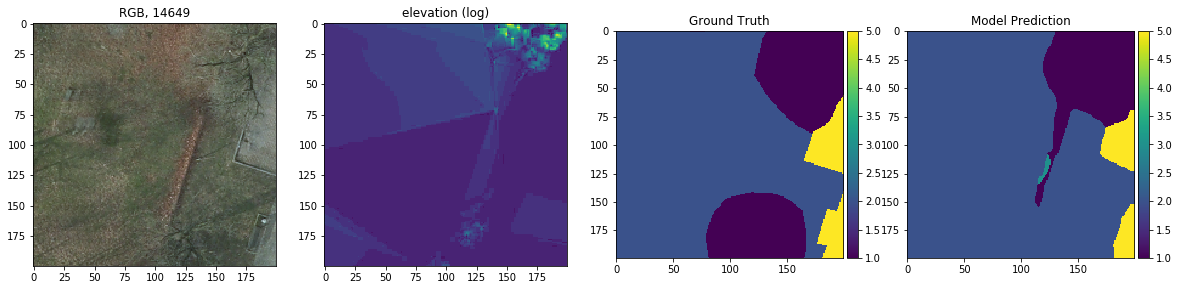

In [37]:
plot_input_pred(model_rgbn_conv, batch, labels, val_idx=val_idx)

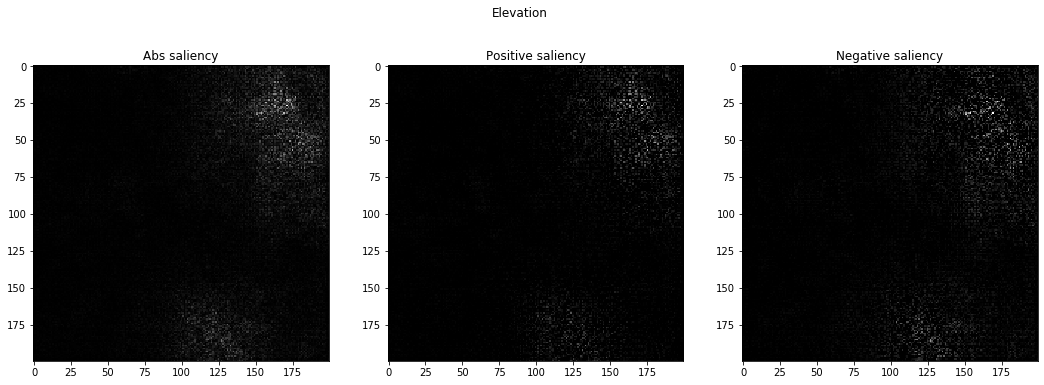

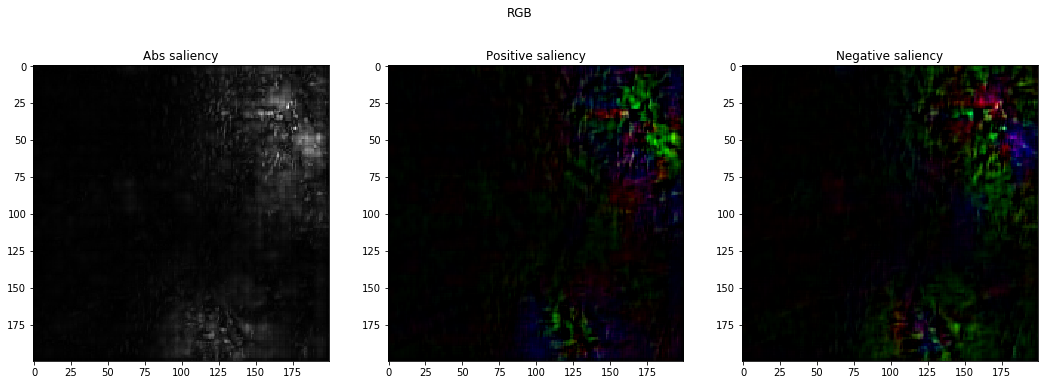

In [38]:
g0 = smooth_grad(bp_n_1, batch.cuda(), labels.cuda(), 1, n=20, std=.1, grad_fn=cat_grads)
g = g0.permute(0, 2, 3, 1).squeeze().detach().cpu()
plot_saliency(g, [3], title='Elevation', cmap='gray')
plot_saliency(g, [0, 1, 2], title='RGB')

## RGBE-1

In [70]:
bp_1 = Backprop(model_rgbe_conv.cuda(), [model_rgbe_conv.m.backbone.conv1.original_conv, model_rgbe_conv.m.backbone.conv1.new_conv])

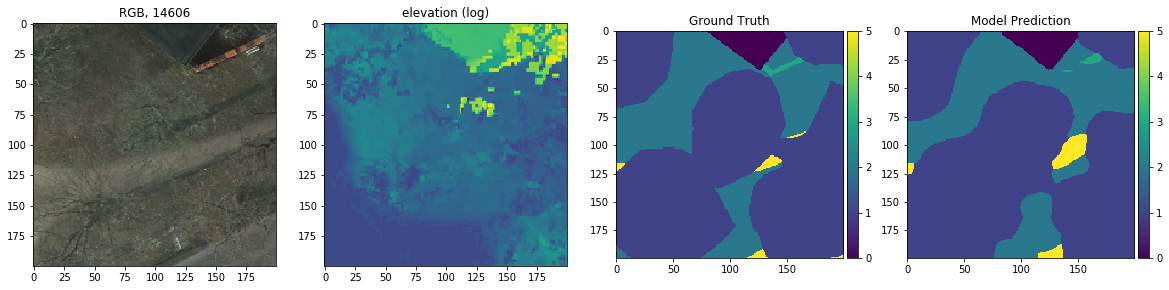

In [71]:
plot_input_pred(model_rgbe_conv, batch, labels, val_idx=val_idx)

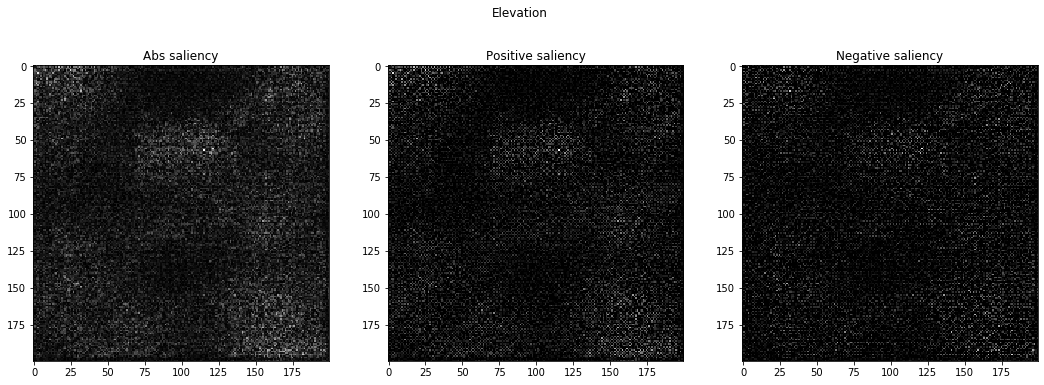

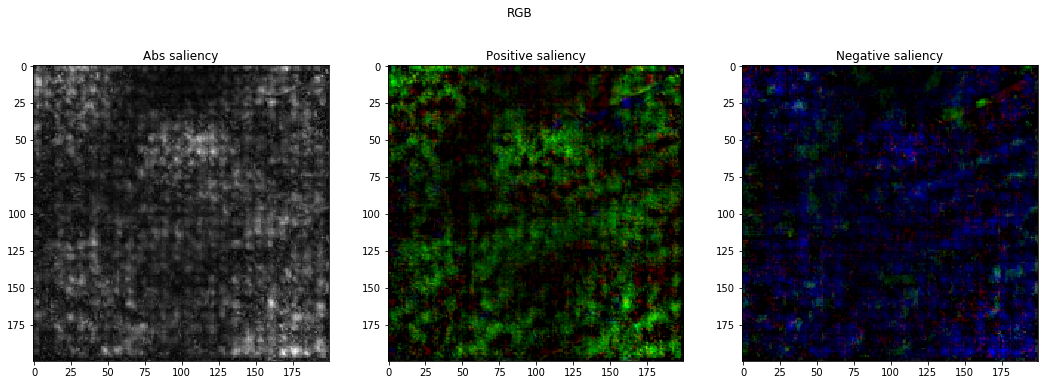

In [75]:
g0 = smooth_grad(bp_1, batch.cuda(), labels.cuda(), 1, n=20, std=.2, grad_fn=cat_grads)
g = g0.permute(0, 2, 3, 1).squeeze().detach().cpu()
plot_saliency(g, [3], title='Elevation', cmap='gray')
plot_saliency(g, [0, 1, 2], title='RGB')

## RGBE-7

In [46]:
bp_7 = Backprop(model_rgbe_7.cuda(), [model_rgbe_7.m.backbone.head[0]])

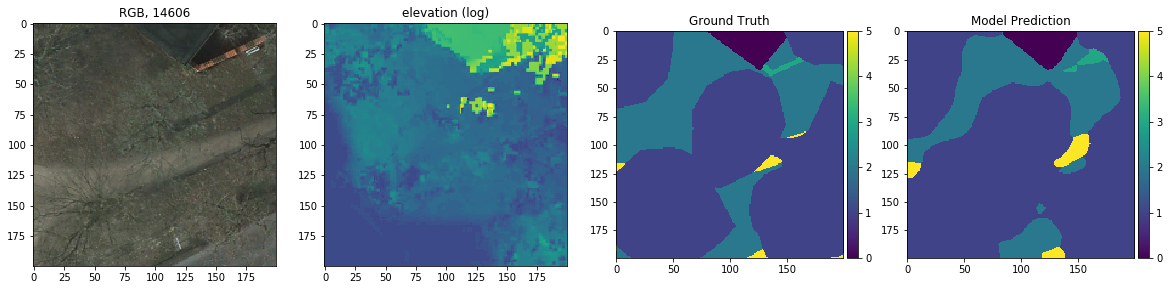

In [54]:
plot_input_pred(model_rgbe_7, batch, labels, val_idx=val_idx)

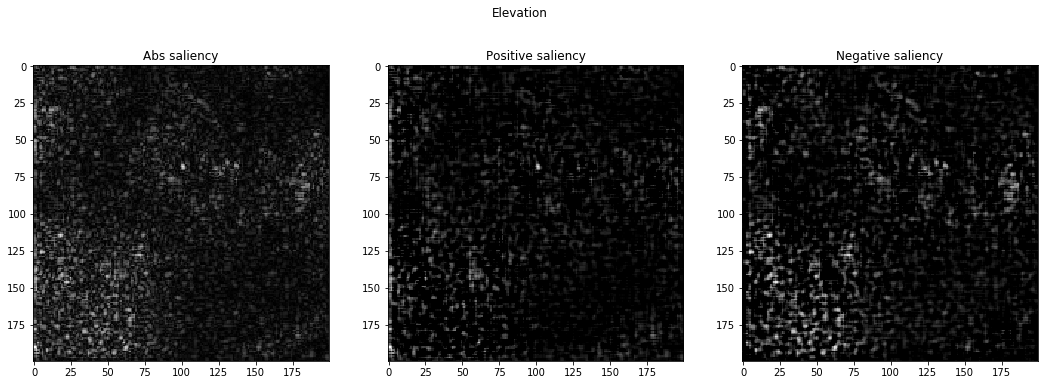

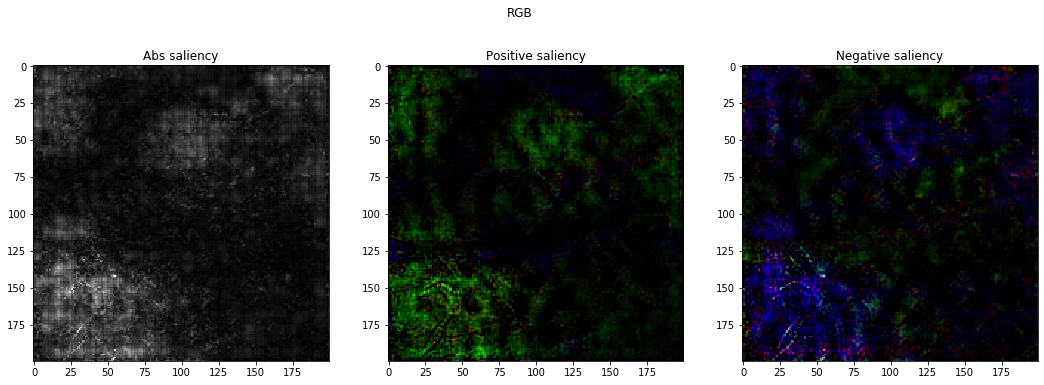

In [55]:
g0 = smooth_grad(bp_7, batch.cuda(), labels.cuda(), 1, n=20, std=.1, grad_fn=cat_grads)
g = g0.permute(0, 2, 3, 1).squeeze().detach().cpu()
plot_saliency(g, [3], title='Elevation', cmap='gray')
plot_saliency(g, [0, 1, 2], title='RGB')

## RGBIRE

In [97]:
bp_rgbire = Backprop(model_rgbire.cuda(), [model_rgbire.m.backbone.conv1])

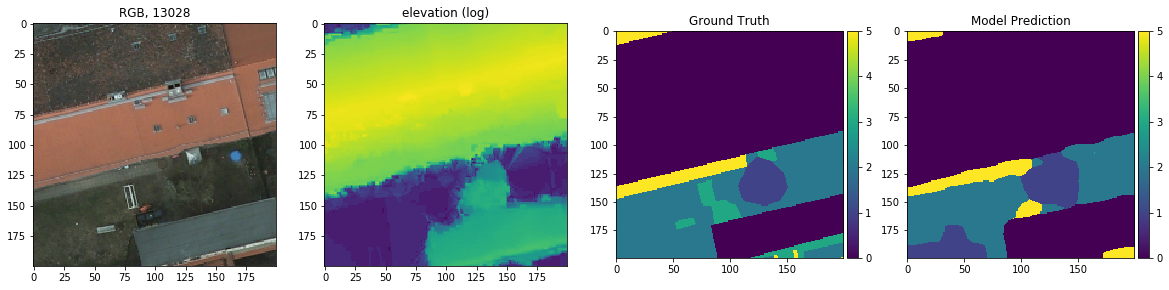

In [104]:
plot_input_pred(model_rgbire, batch_rgbire, labels, val_idx=val_idx)

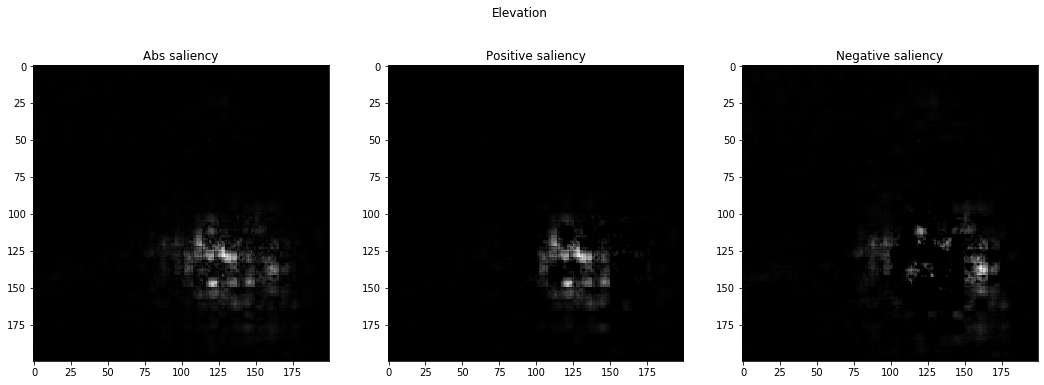

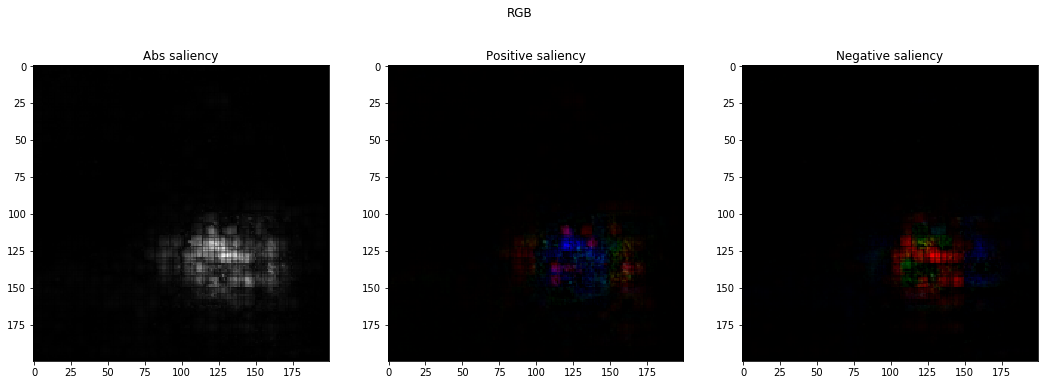

In [105]:
g0 = smooth_grad(bp_rgbire, batch_rgbire.cuda(), labels.cuda(), 1, n=20, std=.1, grad_fn=cat_grads)
g = g0.permute(0, 2, 3, 1).squeeze().detach().cpu()
plot_saliency(g, [3], title='Elevation', cmap='gray')
plot_saliency(g, [0, 1, 2], title='RGB')

# Guided backprop

In [32]:
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model, first_layers):
        self.model = model
        self.first_layers = first_layers
        self.gradients = []
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients.append(grad_in[0])
        # Register hook to the first layer
        for layer in self.first_layers:
            layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for module in self.model.modules():
            if isinstance(module, nn.ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, labels, target_class, correct_class=None):
        if correct_class is None:
            correct_class = target_class
        # Forward pass
        self.gradients = []
        model_output = F.softmax(self.model(input_image), dim=1)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.zeros_like(model_output)
        one_hot_output[:, target_class] = (labels == target_class).float()
#         one_hot_output[:, target_class, 140, 140] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
#         out = (model_output[:, target_class] * (labels == correct_class).float()).sum()

In [33]:
gbp_bb = GuidedBackprop(model_rgbe_7.cuda(), [model_rgbe_7.m.backbone.head[0]])

In [34]:
gbp_bb.generate_gradients(batch.cuda(), labels.cuda(), 1)

In [ ]:
plot_input_pred(model_rgbe_7, batch, labels, val_idx=val_idx)
g = gbp_bb.gradients[0].permute(0, 2, 3, 1).squeeze().detach().cpu()

plot_saliency(g, [3], title='Elevation', cmap='gray')
plot_saliency(g, [0, 1, 2], title='RGB')

In [30]:
gbp = GuidedBackprop(model_rgbe_conv.cuda(), [model_rgbe_conv.m.backbone.conv1.original_conv, model_rgbe_conv.m.backbone.conv1.new_conv])

In [31]:
gbp.generate_gradients(batch.cuda(), labels.cuda(), 1)

In [ ]:
plot_input_pred(model_rgbe_conv, batch, labels, val_idx=val_idx)

g0 = torch.cat((gbp.gradients[1], gbp.gradients[0]), dim=1)
g = g0.permute(0, 2, 3, 1).squeeze().detach().cpu()

plot_saliency(g, [3], title='Elevation', cmap='gray')
plot_saliency(g, [0, 1, 2], title='RGB')